In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
from omtra.load.quick import datamodule_from_config
import omtra.load.quick as quick_load

cfg = quick_load.load_cfg(overrides=['task_group=flexible_protein_pharm_conditioning_cond_a']) # you can provide overrides to the default config via command-line syntax here
datamodule = datamodule_from_config(cfg)
train_dataset = datamodule.load_dataset("val")
plinder_dataset = train_dataset.datasets['plinder']['no_links']
lig = plinder_dataset[('protein_ligand_pharmacophore_denovo_condensed', 8)]

⚛ Instantiating datamodule <omtra.dataset.data_module.MultiTaskDataModule>


In [12]:
import zarr
store = '/net/galaxy/home/koes/icd3/moldiff/OMTRA/data/pharmit/train.zarr'
store = '/net/galaxy/home/koes/ltoft/OMTRA/data/plinder/exp/train.zarr'
root = zarr.open(store, mode="r")
# pharm_node_group = root['pharm/node']
# pharm_node_group['graph_lookup'][1]

In [14]:
root['pharmacophore/interactions'][0]

array(False)

In [13]:
root.tree()

/net/galaxy/home/koes/ltoft/.conda/envs/omtra/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/net/galaxy/home/koes/ltoft/.conda/envs/omtra/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/net/galaxy/home/koes/ltoft/.conda/envs/omtra/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/net/galaxy/home/koes/ltoft/.conda/envs/omtra/

/
├── apo
│   ├── atom_names (372923473,) object
│   ├── backbone_chain_ids (48123567,) object
│   ├── backbone_coords (48123567, 3, 3) float32
│   ├── backbone_mask (372923473,) bool
│   ├── backbone_res_ids (48123567,) int32
│   ├── backbone_res_names (48123567,) object
│   ├── chain_ids (372923473,) object
│   ├── coords (372923473, 3) float32
│   ├── elements (372923473,) object
│   ├── res_ids (372923473,) int32
│   └── res_names (372923473,) object
├── ligand
│   ├── atom_charges (3694127,) float32
│   ├── atom_types (3694127,) int32
│   ├── bond_indices (3927320, 2) int32
│   ├── bond_types (3927320,) int32
│   ├── coords (3694127, 3) float32
│   └── extra_feats (3694127, 6) int8
├── npnde
│   ├── atom_charges (4025,) float32
│   ├── atom_types (4025,) int32
│   ├── bond_indices (3996, 2) int32
│   ├── bond_types (3996,) int32
│   └── coords (4025, 3) float32
├── pharmacophore
│   ├── coords (2179024, 3) float32
│   ├── interactions (2179024,) bool
│   ├── types (2179024,) int32
│   └── vectors (2179024, 4, 3) float32
├── pocket
│   ├── atom_names (46262456,) object
│   ├── backbone_chain_ids (5881833,) object
│   ├── backbone_coords (5881833, 3, 3) float32
│   ├── backbone_mask (46262456,) bool
│   ├── backbone_res_ids (5881833,) int32
│   ├── backbone_res_names (5881833,) object
│   ├── chain_ids (46262456,) object
│   ├── coords (46262456, 3) float32
│   ├── elements (46262456,) object
│   ├── res_ids (46262456,) int32
│   └── res_names (46262456,) object
├── pred
│   ├── atom_names (0,) object
│   ├── backbone_chain_ids (0,) object
│   ├── backbone_coords (0, 3, 3) float32
│   ├── backbone_mask (0,) bool
│   ├── backbone_res_ids (0,) int32
│   ├── backbone_res_names (0,) object
│   ├── chain_ids (0,) object
│   ├── coords (0, 3) float32
│   ├── elements (0,) object
│   ├── res_ids (0,) int32
│   └── res_names (0,) object
└── receptor
    ├── atom_names (372923473,) object
    ├── backbone_chain_ids (48123567,) object
    ├── backbone_coords (48123567, 3, 3) float32
    ├── backbone_mask (372923473,) bool
    ├── backbone_res_ids (48123567,) int32
    ├── backbone_res_names (48123567,) object
    ├── chain_ids (372923473,) object
    ├── coords (372923473, 3) float32
    ├── elements (372923473,) object
    ├── res_ids (372923473,) int32
    └── res_names (372923473,) object

# Model Comparison

In [3]:
def compare_dist_w_true(data, metric, labels):

    flierprops = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgewidth=0)

    # Boxplot
    sns.boxplot(data=data, x="model", y=metric, hue="model", flierprops=flierprops, showfliers=True, palette="Set2")

    y_lower, y_upper = labels['bounds']

    plt.title(labels['title'])
    plt.xlabel(None)
    plt.xticks(rotation=30)
    plt.ylabel(labels['ylabel'])
    plt.ylim(y_lower, y_upper)
    plt.show()
        

def generate_plots(data):

    # generic box plots
    metrics = {'minimizedAffinity': {'title': 'Vina', 'ylabel': 'Vina score (kcal/mol)', 'bounds': (-15,10)},
               'vina_min': {'title': 'Vina min', 'ylabel': 'Vina min score (kcal/mol)', 'bounds': (-15, 10)},
               'strain': {'title': 'Strain', 'ylabel': 'Strain energy', 'bounds': (-10, 1000)},
               'clashes': {'title': 'Clashes', 'ylabel': '# clashes', 'bounds': (-5, 80)}}
   
    for metric, labels in metrics.items():
        compare_dist_w_true(data=data, metric=metric, labels=labels)


    # vina score system-level comparison
    sys_avg_data = data.groupby(['model', 'sys_id'])["minimizedAffinity"].mean().reset_index()

    # Sort by ascending vina score
    sys_order = sys_avg_data[sys_avg_data["model"] == "true"].sort_values("minimizedAffinity", ascending=False)["sys_id"].tolist()
    sys_avg_data["sys_id"] = pd.Categorical(sys_avg_data["sys_id"], categories=sys_order, ordered=True)
    
    plt.figure(figsize=(12, 6))

    sns.lineplot(
        x="sys_id", 
        y="minimizedAffinity", 
        hue="model", 
        data=sys_avg_data, 
        palette='Set2',
        legend=False
    )

    sns.scatterplot(
        x="sys_id", 
        y="minimizedAffinity", 
        hue="model", 
        data=sys_avg_data, 
        palette='Set2',
    )

    plt.gca().invert_yaxis()

    labels = plt.gca().get_xticklabels()
    for i, label in enumerate(labels):
        if i % 5 != 0:
            label.set_visible(False)

    ax = plt.gca()
    for pos in range(0, len(sys_order), 5):
        ax.axvline(x=pos, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
        
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Mean Vina score")
    plt.tight_layout()
    plt.show()

    # rmsd
    plt.figure(figsize=(6,4))
    flierprops = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgewidth=0)
    # Boxplot
    sns.boxplot(data=data[data['model'] != 'true'], x="model", y='rmsd', hue="model", flierprops=flierprops, showfliers=True, palette="Set2")

    plt.title('RMSD')
    plt.xlabel(None)
    plt.xticks(rotation=30)
    plt.ylabel('RMSD')
    plt.show()


def pb_validity_summary(data):
    avg_pb_metrics = {}

    for col in data.columns:
        avg_pb_metrics[col] = data[col].mean()

    sorted_pb_metrics = sorted(avg_pb_metrics.items(), key=lambda item: item[1])

    # Print sorted key-value pairs
    for key, value in sorted_pb_metrics:
        print(f"{key}: {value}")

In [15]:
# rigid docking
rd_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_MID/rigid_docking_condensed_metrics.csv')
rd_metrics['model'] = 'rigid_docking'
# flexible docking
fd_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_MID/flexible_docking_condensed_metrics.csv')
fd_metrics['model'] = 'flexible_docking'

# rigid protein, ligand de novo
rdenovo_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_MID/fixed_protein_ligand_denovo_condensed_metrics.csv')
rdenovo_metrics['model'] = 'rigid_prot_lig_denovo'
# flexible protein, ligand de novo
fdenovo_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_MID/protein_ligand_denovo_condensed_metrics.csv')
fdenovo_metrics['model'] = 'flexible_prot_lig_denovo'

In [30]:
rdenovo_metrics[rdenovo_metrics['sys_id'] == 'sys_3_gt']

,sys_id,protein_id,gen_ligand_id,pb_mol_pred_loaded,pb_mol_cond_loaded,pb_sanitization,pb_inchi_convertible,pb_all_atoms_connected,pb_bond_lengths,pb_bond_angles,...,strain_true,HBAcceptor_true,HBDonor_true,Hydrophobic_true,PiStacking_true,rmsd,system_id,ligand_id,ccd,model
145,sys_3_gt,protein_0,gen_ligands_0,True,True,True,True,True,True,True,...,23.510274,0.555556,0.222222,0.0,0.0,NaN,5yft__1__2.C__2.N,2.N,RI2,rigid_prot_lig_denovo
146,sys_3_gt,protein_0,gen_ligands_1,True,True,True,True,True,True,True,...,23.510274,0.555556,0.222222,0.0,0.0,0.809993,5yft__1__2.C__2.N,2.N,RI2,rigid_prot_lig_denovo
147,sys_3_gt,protein_0,gen_ligands_2,True,True,True,True,True,False,True,...,23.510274,0.555556,0.222222,0.0,0.0,NaN,5yft__1__2.C__2.N,2.N,RI2,rigid_prot_lig_denovo
148,sys_3_gt,protein_0,gen_ligands_3,True,True,True,True,True,True,True,...,23.510274,0.555556,0.222222,0.0,0.0,NaN,5yft__1__2.C__2.N,2.N,RI2,rigid_prot_lig_denovo
149,sys_3_gt,protein_0,gen_ligands_4,True,True,True,True,True,True,True,...,23.510274,0.555556,0.222222,0.0,0.0,NaN,5yft__1__2.C__2.N,2.N,RI2,rigid_prot_lig_denovo
150,sys_3_gt,protein_0,gen_ligands_5,True,True,True,True,True,True,True,...,23.510274,0.555556,0.222222,0.0,0.0,NaN,5yft__1__2.C__2.N,2.N,RI2,rigid_prot_lig_denovo
151,sys_3_gt,protein_0,gen_ligands_9,True,True,True,True,True,False,True,...,23.510274,0.555556,0.222222,0.0,0.0,NaN,5yft__1__2.C__2.N,2.N,RI2,rigid_prot_lig_denovo
152,sys_3_gt,protein_0,gen_ligands_12,True,True,True,True,True,True,True,...,23.510274,0.555556,0.222222,0.0,0.0,NaN,5yft__1__2.C__2.N,2.N,RI2,rigid_prot_lig_denovo
153,sys_3_gt,protein_0,gen_ligands_13,True,True,True,True,True,True,True,...,23.510274,0.555556,0.222222,0.0,0.0,NaN,5yft__1__2.C__2.N,2.N,RI2,rigid_prot_lig_denovo
154,sys_3_gt,protein_0,gen_ligands_15,True,True,True,True,True,True,True,...,23.510274,0.555556,0.222222,0.0,0.0,NaN,5yft__1__2.C__2.N,2.N,RI2,rigid_prot_lig_denovo


In [ ]:
for i in range(50):
    print(i, rdenovo_metrics[rdenovo_metrics['sys_id'] == f'sys_{i}_gt'].shape[0])

0 50
1 49
2 46
3 35
4 50
5 50
6 49
7 49
8 50
9 50
10 49
11 47
12 49
13 50
14 49
15 50
16 50
17 49
18 49
19 50
20 46
21 45
22 49
23 48
24 49
25 45
26 49
27 45
28 48
29 49
30 45
31 41
32 47
33 40
34 48
35 50
36 48
37 45
38 48
39 49
40 44
41 47
42 48
43 48
44 46
45 48
46 41
47 49
48 49
49 50


In [5]:
true = rd_metrics[[col for col in rd_metrics.columns if '_true' in col and 'pb_mol_true_loaded' != col]].copy()
true.columns = [col[:-5] for col in true]
true[['sys_id', 'system_id', 'ligand_id', 'ccd']] = rd_metrics[['sys_id', 'system_id', 'ligand_id', 'ccd']]
true['model'] = 'true'
true = true.drop_duplicates(subset=['sys_id'])
true

,pb_mol_pred_loaded,pb_mol_cond_loaded,pb_sanitization,pb_inchi_convertible,pb_all_atoms_connected,pb_bond_lengths,pb_bond_angles,pb_internal_steric_clash,pb_aromatic_ring_flatness,pb_non-aromatic_ring_non-flatness,...,strain,HBAcceptor,HBDonor,Hydrophobic,PiStacking,sys_id,system_id,ligand_id,ccd,model
0,True,True,True,True,True,True,True,True,True,True,...,4.336892e+00,0.333333,0.222222,0.000000,0.0,sys_0_gt,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,true
50,True,True,True,True,True,True,True,True,True,True,...,4.397937e+02,0.161290,0.032258,0.096774,0.0,sys_1_gt,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.K,ATP,true
100,True,True,True,True,True,True,True,True,True,True,...,2.431327e+01,0.166667,0.166667,0.083333,0.0,sys_2_gt,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.L,CIR,true
150,True,True,True,True,True,True,True,True,True,True,...,2.351027e+01,0.555556,0.222222,0.000000,0.0,sys_3_gt,5yft__1__2.C__2.N,2.N,RI2,true
200,True,True,True,True,True,True,True,True,True,True,...,3.688895e+01,0.153846,0.115385,0.269231,0.0,sys_4_gt,4rrd__1__1.A_2.A__1.B,1.B,A3T,true
250,True,True,True,True,True,True,True,True,True,True,...,2.029865e+01,0.051282,0.051282,0.076923,0.0,sys_5_gt,3t1n__2__1.B__1.D,1.D,SEP-ASP-GLU-PHE,true
300,True,True,True,True,True,True,True,True,True,True,...,3.254752e+01,0.111111,0.111111,0.185185,0.0,sys_6_gt,6jat__1__1.A_1.B__1.E,1.E,SFG,true
350,True,True,True,True,True,True,True,True,True,True,...,7.915093e+00,0.105263,0.105263,0.368421,0.0,sys_7_gt,6c3u__1__1.A_1.B__1.G_1.H,1.G,NY2,true
400,True,True,True,True,True,True,True,True,True,True,...,6.161298e+01,0.129032,0.064516,0.129032,0.0,sys_8_gt,4jxx__1__1.A__1.C,1.C,ATP,true
450,True,True,True,True,True,True,True,True,True,True,...,3.476261e+01,0.064516,0.064516,0.064516,0.0,sys_9_gt,4bls__1__1.B_1.C__1.F,1.F,APC,true


In [6]:
all_results = pd.concat([rd_metrics, fd_metrics, rdenovo_metrics, fdenovo_metrics, true], ignore_index=True)
all_results.drop(columns=[col for col in all_results.columns if '_true' in col and 'pb_mol_true_loaded' != col], inplace=True)
all_results

,sys_id,protein_id,gen_ligand_id,pb_mol_pred_loaded,pb_mol_true_loaded,pb_mol_cond_loaded,pb_sanitization,pb_inchi_convertible,pb_all_atoms_connected,pb_molecular_formula,...,strain,HBAcceptor,HBDonor,Hydrophobic,PiStacking,rmsd,system_id,ligand_id,ccd,model
0,sys_0_gt,protein_0,gen_ligands_0,True,True,True,True,True,True,True,...,116.660595,0.222222,0.000000,0.000000,0.0,1.227744,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking
1,sys_0_gt,protein_0,gen_ligands_1,True,True,True,True,True,True,True,...,7.409277,0.222222,0.000000,0.000000,0.0,1.858384,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking
2,sys_0_gt,protein_0,gen_ligands_2,True,True,True,True,True,True,True,...,12.972030,0.222222,0.000000,0.000000,0.0,1.955112,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking
3,sys_0_gt,protein_0,gen_ligands_3,True,True,True,True,True,True,True,...,10.664836,0.333333,0.222222,0.000000,0.0,2.997708,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking
4,sys_0_gt,protein_0,gen_ligands_4,True,True,True,True,True,True,True,...,9.009903,0.333333,0.111111,0.111111,0.0,2.897168,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9870,sys_45_gt,NaN,NaN,True,NaN,True,True,True,True,NaN,...,39.482354,0.300000,0.150000,0.200000,0.0,NaN,5b5t__2__1.C_1.D__1.G,1.G,6FY,true
9871,sys_46_gt,NaN,NaN,True,NaN,True,True,True,True,NaN,...,15.816678,0.538462,0.153846,0.076923,0.0,NaN,5eu9__2__1.C__1.O_1.P_1.R,1.R,5TX,true
9872,sys_47_gt,NaN,NaN,True,NaN,True,True,True,True,NaN,...,22.018074,0.066667,0.133333,0.000000,0.0,NaN,7xxc__1__1.A_1.B_1.C__1.J,1.J,I55,true
9873,sys_48_gt,NaN,NaN,True,NaN,True,True,True,True,NaN,...,4.492251,0.300000,0.300000,0.400000,0.0,NaN,2znz__2__1.G_1.H_2.F__2.N,2.N,LYS,true


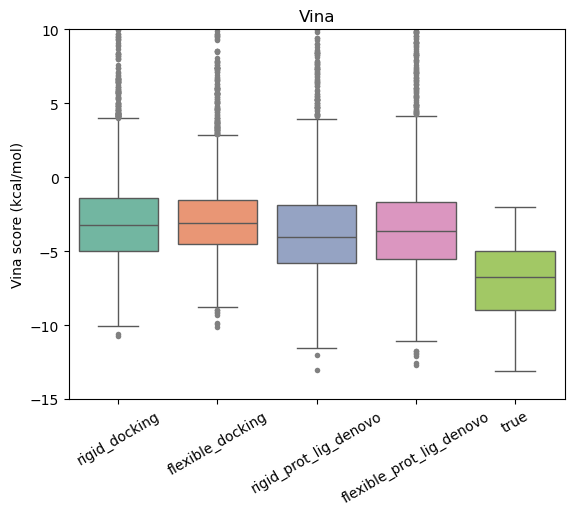

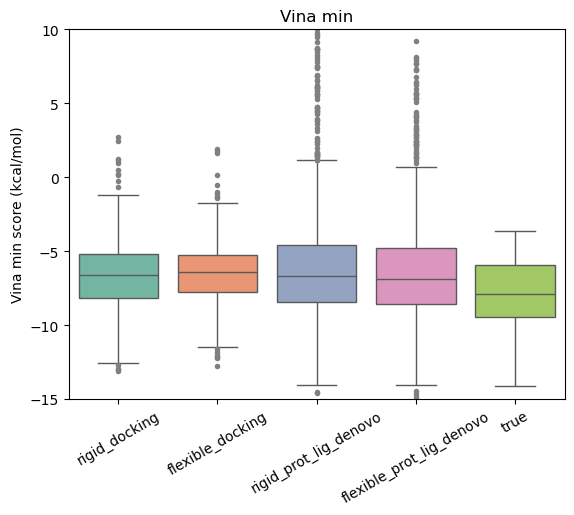

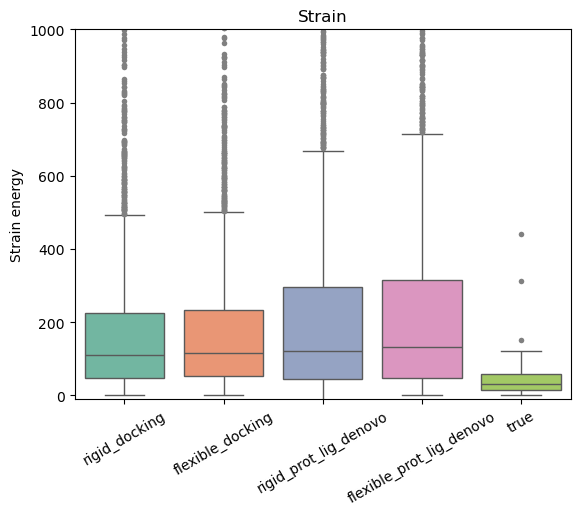

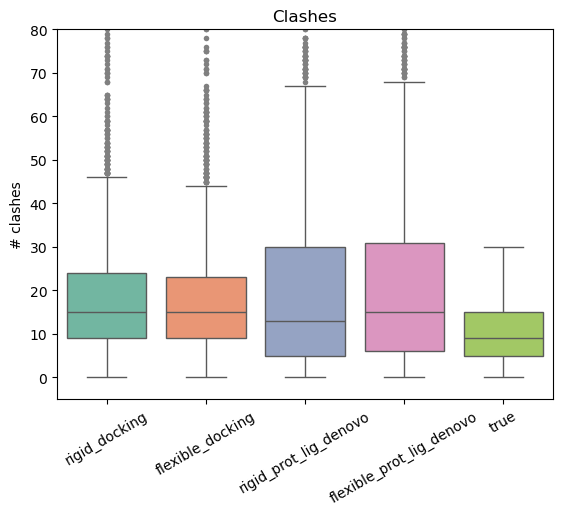

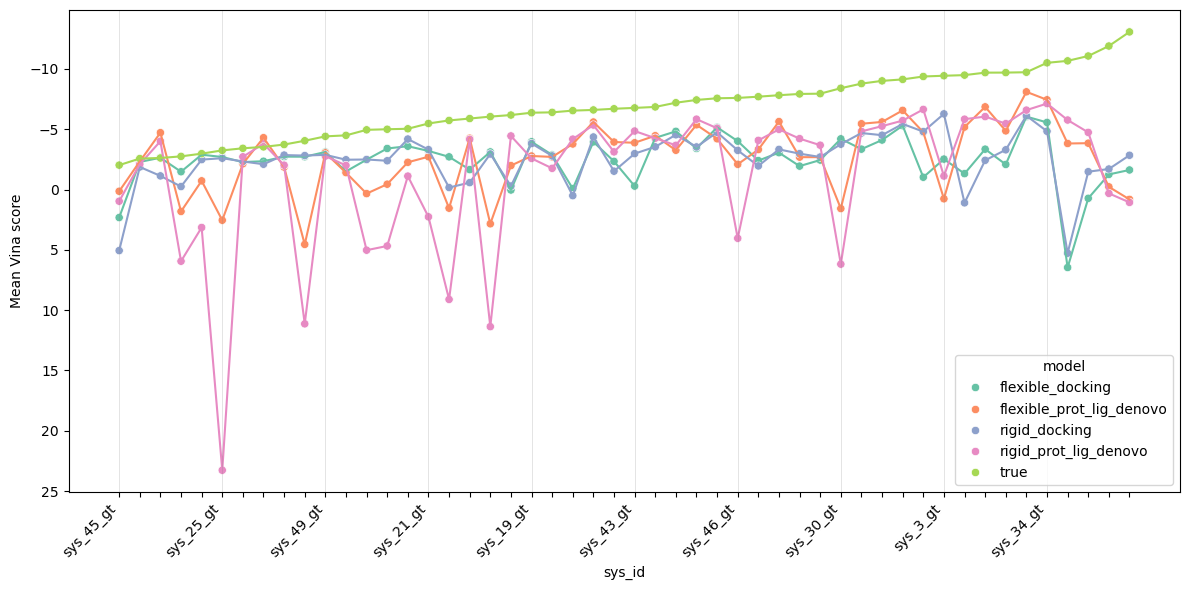

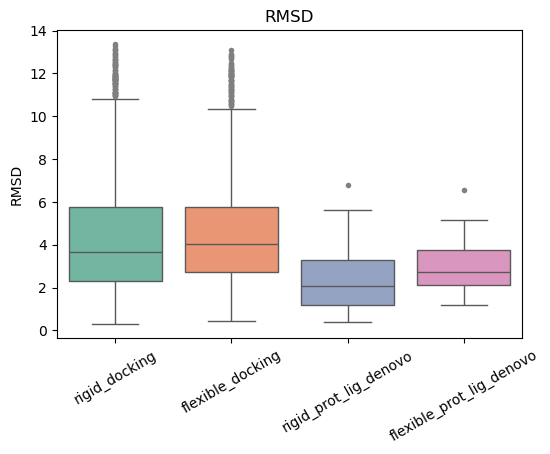

In [6]:
generate_plots(all_results)

In [ ]:
# PoseBusters checks
pb_checks = [col for col in all_results if 'pb_' in col]
pb = all_results.copy()
pb = pb[pb_checks].copy()
pb[['model','sys_id']] = all_results[['model', 'sys_id']]

pb_summary = pd.DataFrame(index=pb_checks, columns=all_results['model'].unique())

for check in pb_checks:
    pb[check] = pd.to_numeric(pb[check], errors='coerce')
    sys_avg = pb.groupby(['model', 'sys_id'])[check].mean()
    model_avg = sys_avg.groupby('model').mean()

    pb_summary.loc[check, :] = model_avg

pb_summary

,rigid_docking,flexible_docking,rigid_prot_lig_denovo,flexible_prot_lig_denovo,true
pb_mol_pred_loaded,1.0,1.0,1.0,1.0,1.0
pb_mol_true_loaded,1.0,1.0,NaN,NaN,NaN
pb_mol_cond_loaded,1.0,1.0,1.0,1.0,1.0
pb_sanitization,1.0,1.0,1.0,1.0,1.0
pb_inchi_convertible,1.0,1.0,1.0,1.0,1.0
pb_all_atoms_connected,1.0,1.0,0.94896,0.952702,1.0
pb_molecular_formula,1.0,1.0,NaN,NaN,NaN
pb_molecular_bonds,1.0,1.0,NaN,NaN,NaN
pb_double_bond_stereochemistry,1.0,1.0,NaN,NaN,NaN
pb_tetrahedral_chirality,0.3864,0.44,NaN,NaN,NaN


In [8]:
# Table 2 from FLOWR
# 100 samples, 100 replicates

summary_table_1 = pd.DataFrame(index=all_results['model'].unique())
table_metrics = {'pb_valid': 'PB-valid',
                 'strain': 'Strain',
                 'minimizedAffinity': 'Vina score',
                 'vina_min': 'Vina min score',
                 'rmsd': 'RMSD'}

for metric, name in table_metrics.items():
    # ensure numeric; non-numeric -> NaN
    all_results[metric] = pd.to_numeric(all_results[metric], errors='coerce')
    
    sys_avg = all_results.groupby(['model', 'sys_id'])[metric].mean()
    mean = sys_avg.groupby('model').mean()
    std = sys_avg.groupby('model').std()
    
    # safely handle NaNs in formatting
    summary_table_1[name] = mean.round(3).astype(str).fillna('NaN') + " ± " + std.round(3).astype(str).fillna('NaN')

summary_table_1

,PB-valid,Strain,Vina score,Vina min score,RMSD
rigid_docking,0.062 ± 0.093,235.763 ± 275.63,-2.527 ± 2.233,-6.717 ± 1.735,4.262 ± 1.424
flexible_docking,0.04 ± 0.077,222.067 ± 180.528,-2.48 ± 2.042,-6.507 ± 1.454,4.494 ± 1.563
rigid_prot_lig_denovo,0.488 ± 0.265,1259.884 ± 3953.658,-1.268 ± 5.856,-5.853 ± 3.158,1.997 ± 1.008
flexible_prot_lig_denovo,0.466 ± 0.242,311.564 ± 177.212,-2.687 ± 2.818,-6.459 ± 2.128,2.514 ± 1.028
true,0.9 ± 0.303,51.573 ± 74.986,-6.829 ± 2.666,-7.92 ± 2.5,nan ± nan


In [9]:
# Table 2 from DrugFlow

from scipy.stats import wasserstein_distance

models = list(set(all_results['model'].unique()) - {'true'})
summary_table_2 = pd.DataFrame(index=models)
table_metrics = {'minimizedAffinity': 'Vina score',
                 'CNNscore': 'Gnina score',
                 'HBAcceptor': 'H-bond (acc.)',
                 'HBDonor': 'H-bond (don.)',
                 'Hydrophobic': 'Hydrophobic'}

for metric, name in table_metrics.items():
    true_dist = all_results.loc[all_results['model'] == 'true', metric].dropna().astype(np.float64).to_numpy()

    for model in models:
        data_dist = all_results.loc[all_results['model'] == model, metric].dropna().astype(np.float64).to_numpy()
        summary_table_2.loc[model, name] = wasserstein_distance(data_dist, true_dist) 

summary_table_2

,Vina score,Gnina score,H-bond (acc.),H-bond (don.),Hydrophobic
rigid_prot_lig_denovo,5.471798,0.337089,0.078497,0.053599,0.020732
rigid_docking,4.301634,0.465866,0.066566,0.046411,0.026606
flexible_docking,4.348614,0.528529,0.095193,0.052093,0.030831
flexible_prot_lig_denovo,4.144173,0.406689,0.109122,0.060942,0.020510


# Single Model Analysis

In [29]:
metrics_path = '/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_MID/protein_ligand_denovo_condensed_metrics.csv'
data = pd.read_csv(metrics_path)

In [30]:
import matplotlib.pyplot as plt

def plot_by_sys(data, metric, order="desc"):
   
    metric_true = f"{metric}_true"

    # Group by system
    grouped = data.groupby('sys_id')

    # Collect replicates + truths
    replicates = [g[metric].values for _, g in grouped]
    truths = [g[metric_true].iloc[0] for _, g in grouped]
    systems = list(grouped.groups.keys())

    # Sort systems by truth
    reverse = (order == "desc")
    ordered = sorted(zip(systems, replicates, truths), key=lambda x: x[2], reverse=reverse)
    systems, replicates, truths = zip(*ordered)

    # Plot
    fig, ax = plt.subplots(figsize=(12,6))
    bp = ax.boxplot(replicates, positions=range(len(systems)), patch_artist=True)
    ax.scatter(range(len(systems)), truths, color="red", marker="x", s=100, label="Ground truth")

    # Format axes
    ax.set_xticks(range(len(systems)))
    ax.set_xticklabels(systems, rotation=90, ha="right")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric}: replicates vs ground truth (sorted {order})")

    plt.tight_layout()
    return fig, ax

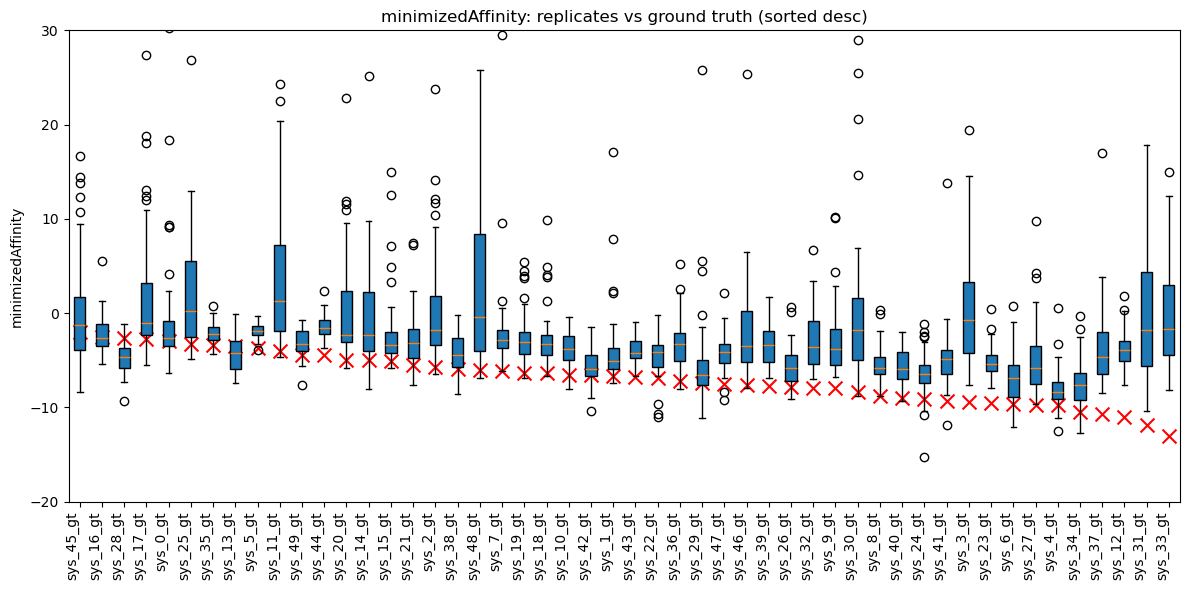

In [31]:
fig, ax = plot_by_sys(data, "minimizedAffinity", order="desc")

ax.set_ylim(-20, 30)
fig.show()

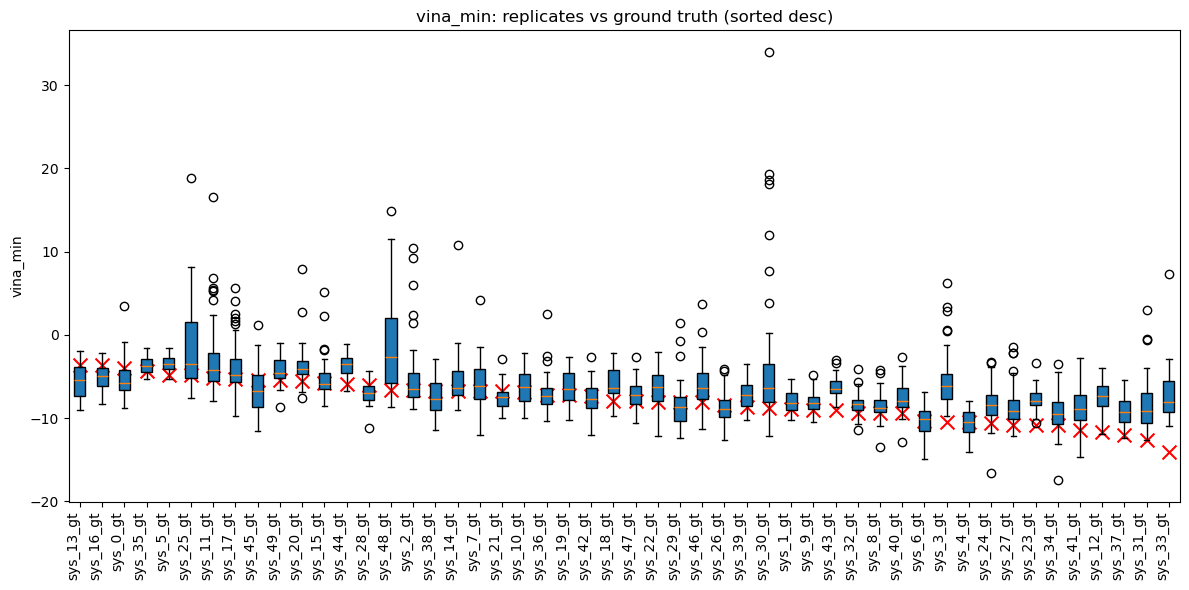

In [32]:
fig, ax = plot_by_sys(data, "vina_min", order="desc")

fig.show()

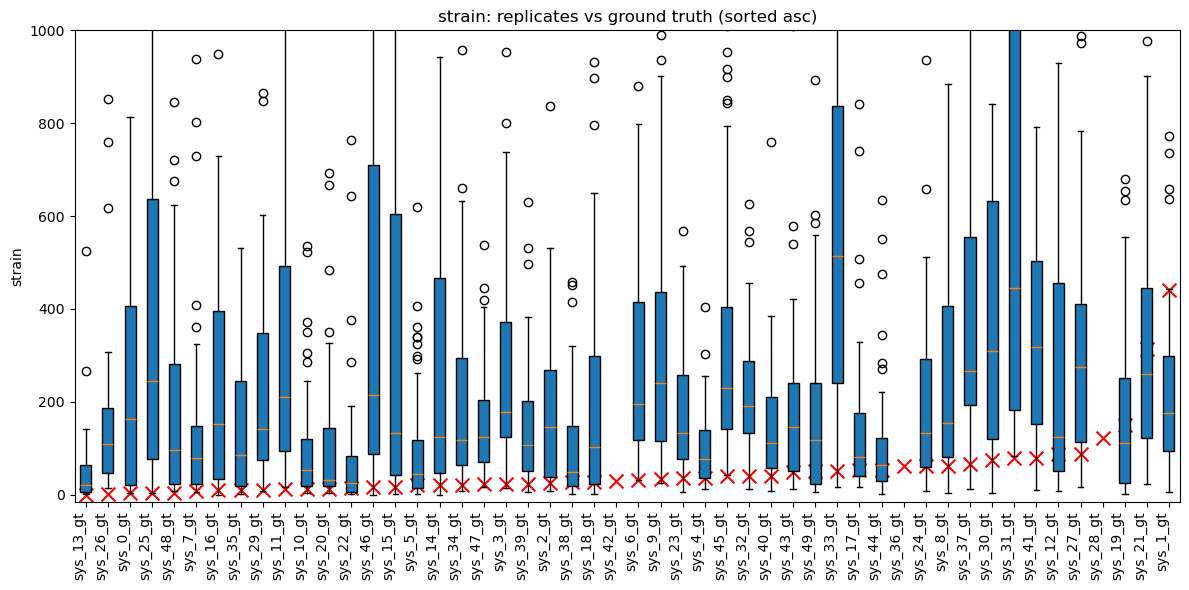

In [33]:
fig, ax = plot_by_sys(data, "strain", order="asc")

ax.set_ylim(-15, 1000)
fig.show()

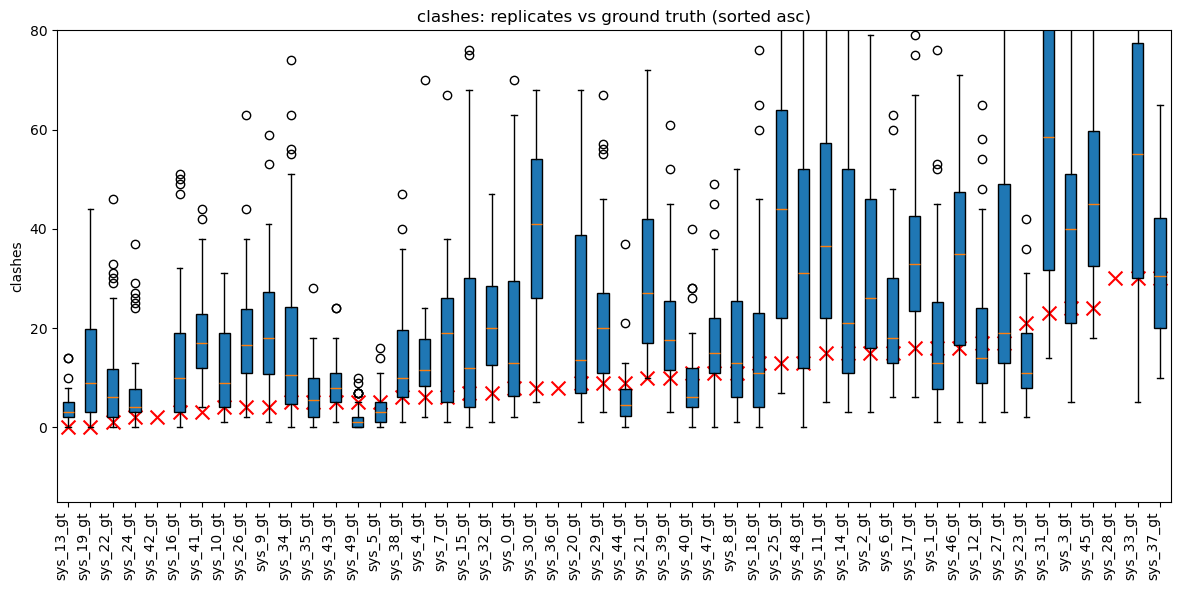

In [34]:
fig, ax = plot_by_sys(data, "clashes", order="asc")

ax.set_ylim(-15, 80)
fig.show()

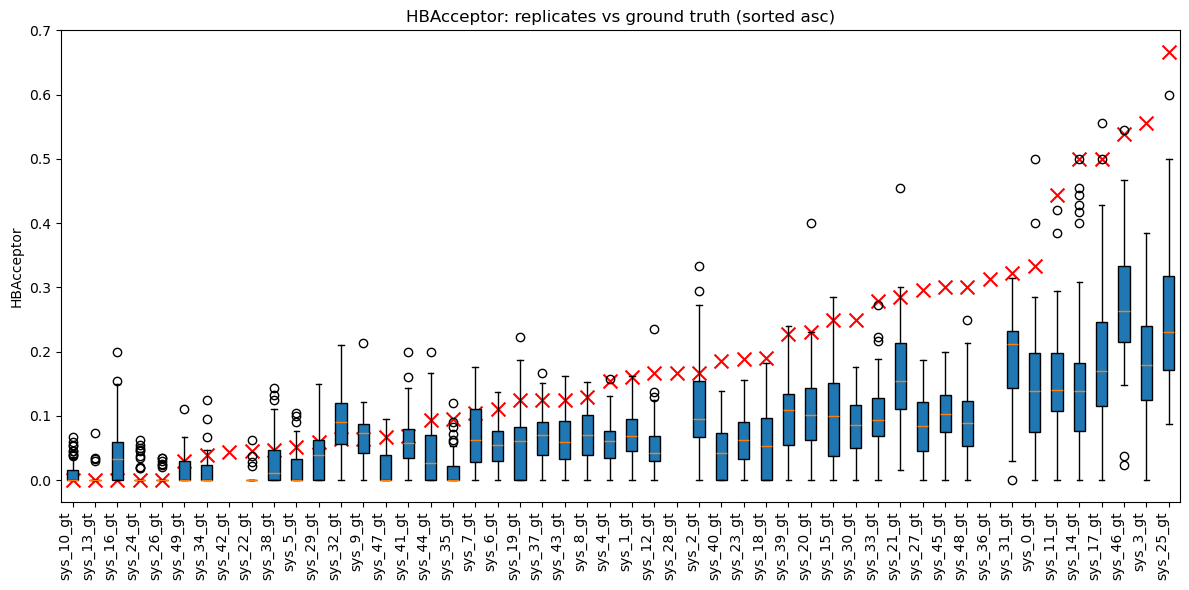

In [35]:
fig, ax = plot_by_sys(data, "HBAcceptor", order="asc")

#ax.set_ylim(-15, 80)
fig.show()

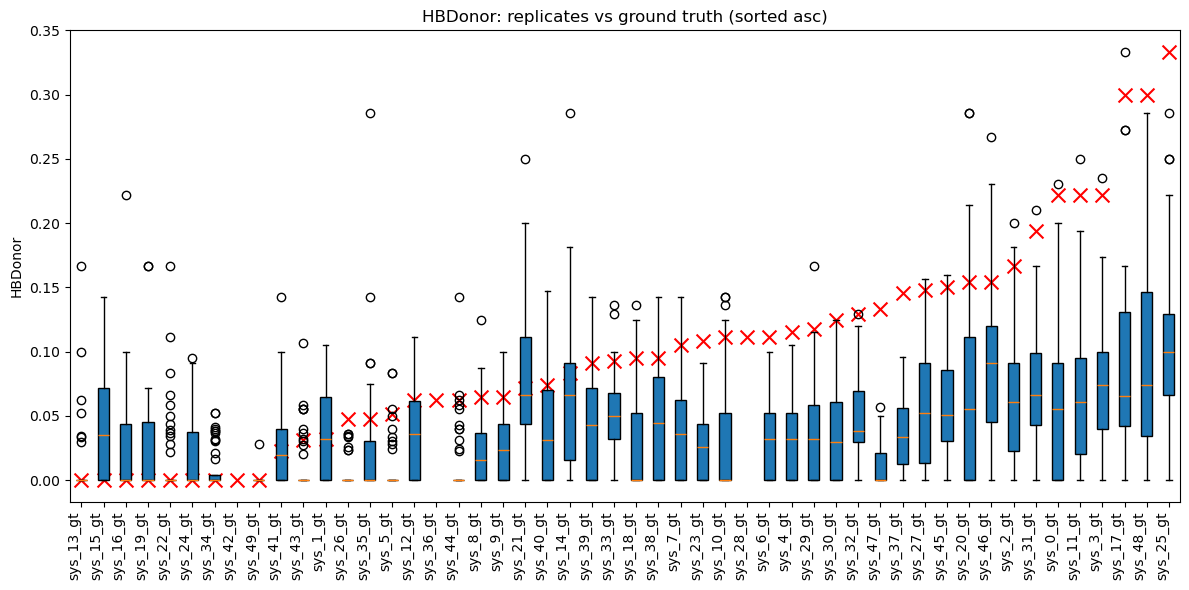

In [36]:
fig, ax = plot_by_sys(data, "HBDonor", order="asc")

#ax.set_ylim(-15, 80)
fig.show()

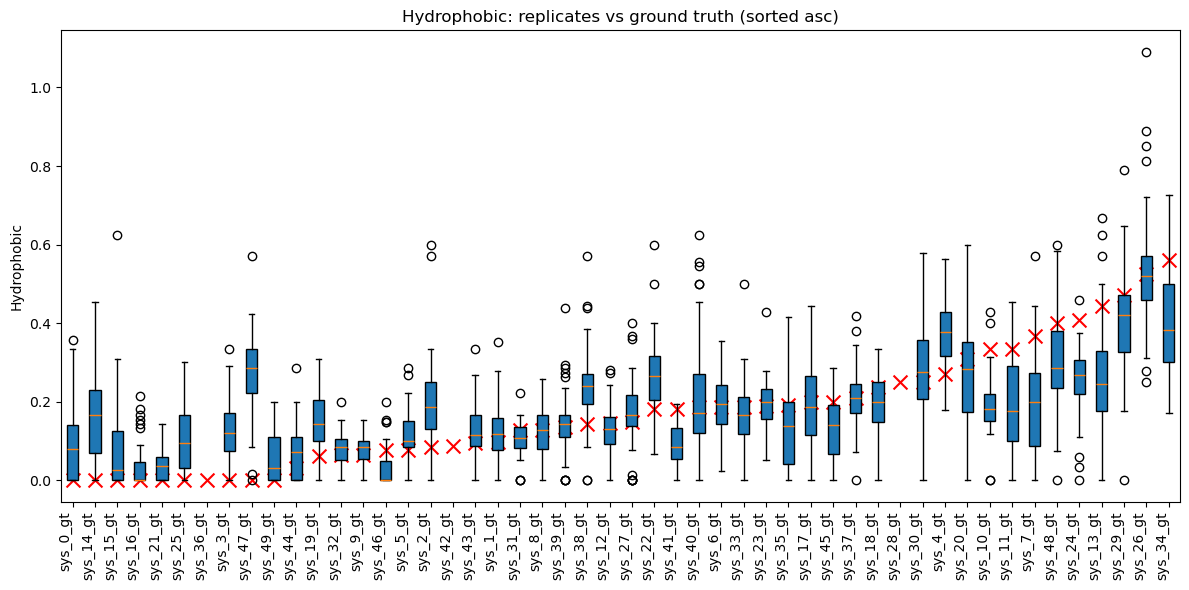

In [37]:
fig, ax = plot_by_sys(data, "Hydrophobic", order="asc")

#ax.set_ylim(-15, 80)
fig.show()